In [1]:
import sys
sys.path.insert(1, '../../decode_eeg/')
import decode_eeg
import numpy as np
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

In [3]:
time_window = 25
time_step = 25
trial_average = 20
n_splits = 500
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub,num_labels=2)

In [4]:
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan


for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync.load_eeg(sub)
    
    for xdata,ydata in sync.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync.balance_labels(xdata,ydata)
        xdata,ydata = sync.average_trials(xdata,ydata)
        xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
        
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [5]:
interp = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_to_conj_set_size_trialbin{trial_average}_')
interp.save_results()
# interp.load_results('single_feature_to_conj_set_size_trialbin20_20200530_1334.pickle')

TypeError: 'int' object is not iterable

TypeError: 'int' object is not iterable

## Prepping conf mat data

In [14]:
interp_single = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_set_size_trialbin{trial_average}_')
interp_single.load_results('single_feat_set_size_trialbin20_20200530_1402.pickle')
conj_conf = interp.conf_mat
sing_conf = interp_single.conf_mat
sing_ids = [123207,123208,123211,123226,123504,123727,123761,124083,124201,124217,124229,124284,124332,124339,124348,124404,124410,124426,124441,124475,124490,124492,124497,124523]
remove_subs_idx = np.isin(sing_ids,sync.matched_ids)
sing_conf = sing_conf[remove_subs_idx]

In [16]:
sing_conf.shape

(20, 2, 60, 500, 2, 2)

In [11]:
def get_norm_sub_means(conf,ss):
    sub_means = np.mean(np.mean(conf[:,ss][:,interp.t>250],2),1)[:,0]
    norm_sub_means = np.empty(sub_means.shape)
    for i in range(sub_means.shape[0]):
        norm_sub_means[i] = (sub_means[i] / sum(sub_means[i]))
    
    return norm_sub_means


In [17]:
import pandas as pd
confs = [conj_conf,sing_conf]
ss = [0,1]
labels = ['single12_1','single12_2','single24_2','single24_4','conj12_1','conj12_2','conj24_2','conj24_4']
i=0
df = pd.DataFrame()
for conf in confs:
    for s in ss:
        cm = get_norm_sub_means(conf,s)
        df[labels[i]] = cm[:,0]
        i +=1
        df[labels[i]] = cm[:,1]
        i +=1

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel

In [66]:
diff_sing = df['single12_2']
diff_conj = df['conj12_2']
ttest_rel(diff_conj,diff_sing)

Ttest_relResult(statistic=-0.003218496618510943, pvalue=0.9974655684991152)

In [67]:
diff_sing = df['single24_4']
diff_conj = df['conj24_4']
ttest_rel(diff_conj,diff_sing,)

Ttest_relResult(statistic=0.21540540949939288, pvalue=0.8317466650081428)

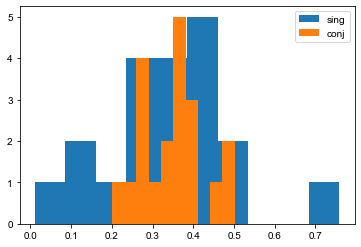

In [68]:
import matplotlib.pyplot as plt
plt.hist(diff_sing)
plt.hist(diff_conj)
plt.legend(['sing','conj'])

In [19]:
vals = np.concatenate((df['single12_1'],df['single12_2'],df['conj12_1'],df['conj12_2']))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['low','high','low','high'],20)

tidy = pd.DataFrame()
tidy['feat'] = feat
tidy['ss'] = ss
tidy['vals'] = vals

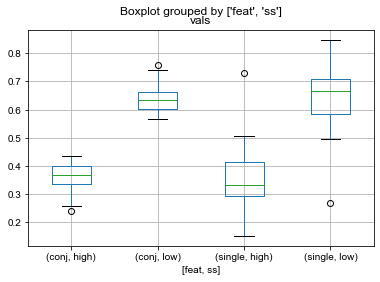

In [20]:
tidy.boxplot(by=['feat','ss'])

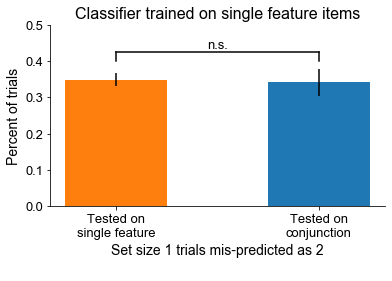

In [105]:
import matplotlib.pyplot as plt
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['Tested on\nsingle feature','Tested on\nconjunction']
x = [1,2]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
ax.bar(2,diff_sing.mean(),yerr=diff_sing.sem(),width=width)
ax.bar(1,diff_conj.mean(),yerr=diff_conj.sem(),width=width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of trials', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Set size 1 trials mis-predicted as 2\n', fontsize=14)

ax.plot([1,1],[.4,.425],c='k')
ax.plot([2,2],[.4,.425],c='k')
ax.plot([1,2],[.425,.425],c='k')
ax.text(1.45,.435,'n.s.',fontsize=13)
ax.set_yticks(np.arange(0,.51,.1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=13)
plt.setp(ax.get_yticklabels(), fontsize=13);
plt.gcf().subplots_adjust(bottom=0.25)
plt.title('Classifier trained on single feature items',fontsize=16)
# plt.savefig('pred_double_12.pdf',dpi=1000)
plt.savefig('pred_double_12.png',dpi=1000)

<BarContainer object of 1 artists>

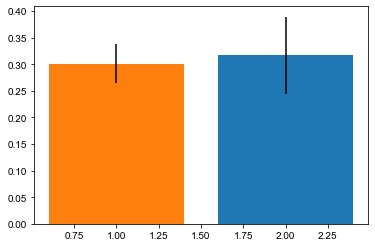

## 1&2

In [ ]:
statsmodels.stats.weightstats.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled', weights=None, None, value=0)

In [21]:
model = ols('vals ~ C(feat) + C(ss) + C(feat):C(ss)', data=tidy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feat),1.017368e-30,1.0,1.040540e-28,1.000000e+00
C(ss),1.577532e+00,1.0,1.613462e+02,1.768978e-20
C(feat):C(ss),1.734303e-07,1.0,1.773803e-05,9.966506e-01
Residual,7.430756e-01,76.0,NaN,NaN


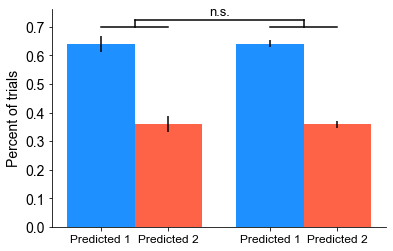

In [22]:
import matplotlib.pyplot as plt
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['Predicted 1','Predicted 2','Predicted 1','Predicted 2']
x = [.75,1.25,2,2.5]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(1 - width/2, group_means.filter(items=['single12_1']), width, color = 'dodgerblue', yerr=group_se.filter(items=['single12_1']))
rects2 = ax.bar(1 + width/2, group_means.filter(items=['single12_2']), width, color='tomato',yerr=group_se.filter(items=['single12_2']))
rects3 = ax.bar(2.25 - width/2, group_means.filter(items=['conj12_1']), width, color = 'dodgerblue',yerr=group_se.filter(items=['conj12_1']))
rects4 = ax.bar(2.25 + width/2, group_means.filter(items=['conj12_2']), width, color='tomato',yerr=group_se.filter(items=['conj12_2']))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of trials', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
ax.plot([1,1],[.7,.725],c='k')
ax.plot([2.25,2.25],[.7,.725],c='k')
ax.plot([1,2.25],[.725,.725],c='k')
ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14);

plt.savefig('pred_double_12.pdf',dpi=1000)
plt.savefig('pred_double_12.png',dpi=1000)

## 2&4

In [435]:
vals = np.concatenate((df['single24_2'],df['single24_4'],df['conj24_2'],df['conj24_4']))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['low','high','low','high'],20)

tidy = pd.DataFrame()
tidy['feat'] = feat
tidy['ss'] = ss
tidy['vals'] = vals

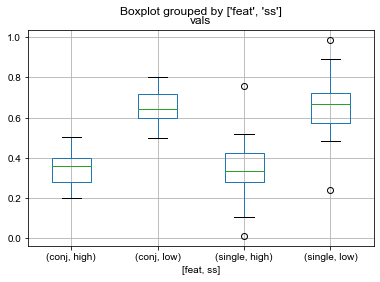

In [436]:
tidy.boxplot(by=['feat','ss'])

In [437]:
model = ols('vals ~ C(feat) + C(ss) + C(feat):C(ss)', data=tidy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feat),8.215483e-31,1.0,4.938447e-29,1.000000e+00
C(ss),1.910280e+00,1.0,1.148297e+02,7.467173e-17
C(feat):C(ss),1.173662e-03,1.0,7.055057e-02,7.912560e-01
Residual,1.264318e+00,76.0,NaN,NaN


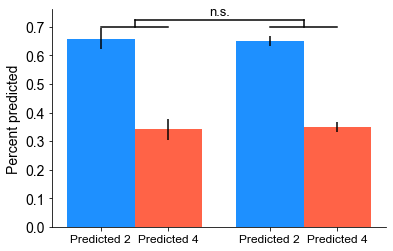

In [25]:
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['Predicted 2','Predicted 4','Predicted 2','Predicted 4']
x = [.75,1.25,2,2.5]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(1 - width/2, group_means.filter(items=['single24_2']), width, color = 'dodgerblue', yerr=group_se.filter(items=['single24_2']))
rects2 = ax.bar(1 + width/2, group_means.filter(items=['single24_4']), width, color='tomato',yerr=group_se.filter(items=['single24_4']))
rects3 = ax.bar(2.25 - width/2, group_means.filter(items=['conj24_2']), width, color = 'dodgerblue',yerr=group_se.filter(items=['conj24_2']))
rects4 = ax.bar(2.25 + width/2, group_means.filter(items=['conj24_4']), width, color='tomato',yerr=group_se.filter(items=['conj24_4']))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent predicted', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
ax.plot([1,1],[.7,.725],c='k')
ax.plot([2.25,2.25],[.7,.725],c='k')
ax.plot([1,2.25],[.725,.725],c='k')
ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14);

plt.savefig('pred_double_24.pdf',dpi=1000)
plt.savefig('pred_double_24.png',dpi=1000)

# testing

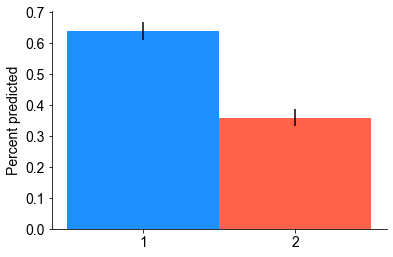

In [17]:
import matplotlib.pyplot as matplotlib
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['1','2'] 
x = [.75,1.25]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(1 - width/2, group_means.filter(items=['single12_1']), width, color = 'dodgerblue', yerr=group_se.filter(items=['single12_1']))
rects2 = ax.bar(1 + width/2, group_means.filter(items=['single12_2']), width, color='tomato',yerr=group_se.filter(items=['single12_2']))
# rects3 = ax.bar(2.25 - width/2, group_means.filter(items=['conj12_1']), width, color = 'dodgerblue',yerr=group_se.filter(items=['conj12_1']))
# rects4 = ax.bar(2.25 + width/2, group_means.filter(items=['conj12_2']), width, color='tomato',yerr=group_se.filter(items=['conj12_2']))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent predicted', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

# ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
# ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
# ax.plot([1,1],[.7,.725],c='k')
# ax.plot([2.25,2.25],[.7,.725],c='k')
# ax.plot([1,2.25],[.725,.725],c='k')
# ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14);

plt.savefig('pred_double_24.pdf',dpi=1000)
plt.savefig('pred_double_24.png',dpi=1000)